In [5]:
import numpy as np
import nibabel as nib

from utils.SAMMed2D_segment_anything import sam_model_registry
from classes.SAMMed2DClass import SAMMed2DInferer, SAMMed2DWrapper

import utils.analysisUtils as anUt
import utils.promptUtils as prUt

from argparse import Namespace

def load_sammed2d(checkpoint_path, device = 'cuda'):
    device = 'cuda'
    args = Namespace()
    args.image_size = 256
    args.encoder_adapter = True
    args.sam_checkpoint = checkpoint_path
    model = sam_model_registry["vit_b"](args).to(device)

    return(model)

def read_im_gt(img_path, gt_path):
    img, gt = nib.load(img_path), nib.load(gt_path)

    ## Check if the volume is already in RAS+
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Image not in RAS. Consider reorienting here')
        img_ras = nib.as_closest_canonical(volume_img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        raise RuntimeWarning('Label not in RAS. Consider reorienting here')
        gt_ras = nib.as_closest_canonical(gt)

    img, gt = img.get_fdata().astype(np.float32), gt.get_fdata().astype(int)
    img, gt = img.transpose(2,1,0), gt.transpose(2,1,0)

    return(img, gt)

# Obtain model and inputs
checkpoint_path = "/home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth"

device = 'cuda'
model = load_sammed2d(checkpoint_path, device)


# Load in image, label, prompt
img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'
img, gt = read_im_gt(img_path, gt_path)


pts_prompt = prUt.get_pos_clicks2D_row_major(gt, 5)

# Perform inference
sam_wrapper = SAMMed2DWrapper(model, device)
segmenter = SAMMed2DInferer(sam_wrapper)


segmentation = segmenter.predict(img, pts_prompt)
anUt.compute_dice(segmentation, gt)

True
*******load /home/t722s/Desktop/UniversalModels/TrainedModels/sam-med2d_b.pth


Performing inference on slices: 100%|██████████| 47/47 [00:01<00:00, 28.14it/s]


0.7853117399299994

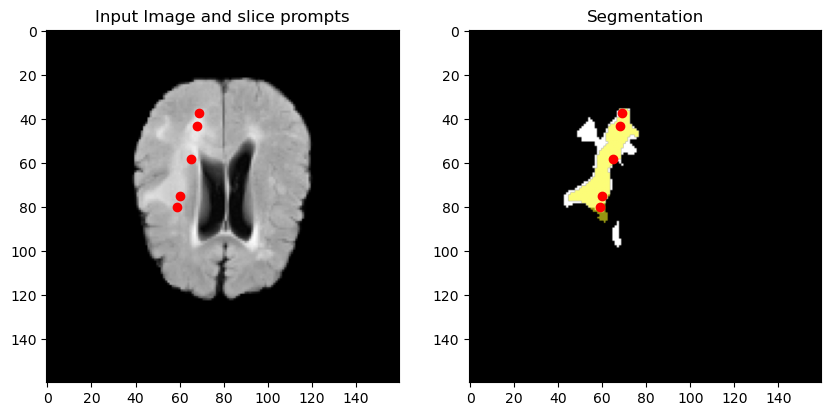

0.7749782797567333

In [6]:
slice_idx = 60
anUt.show_seg_row_major(slice_idx, img, gt, segmentation, pts_prompt = pts_prompt)